In [1]:
%matplotlib ipympl
%env LD_LIBRARY_PATH=/home/kylehsu/miniforge3/envs/modular/lib/:/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/nvidia/cudnn/lib:
import importlib
import metrics
importlib.reload(metrics)
from metrics import compute_linear_metrics
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import omegaconf
import pathlib
import hydra
import jax
import jax.numpy as jnp
import equinox as eqx
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm.notebook as tqdm
from scripts.train_toy import MLPAutoencoder, evaluate, generate_square_data
from scripts.train_autoencoder import batched_x_to_image
import disentangle
sns.set_theme()

env: LD_LIBRARY_PATH=/home/kylehsu/miniforge3/envs/modular/lib/:/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/nvidia/cudnn/lib:


2024-05-22 02:49:57.297551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-22 02:49:57.966138: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
api = wandb.Api()
run_path = 'iris_viscam/modular/81k5w7gi'
step = 9999
run = api.run(run_path)
config = omegaconf.OmegaConf.create(run.config)

dataset_info, train_set, val_set = disentangle.datasets.load(config)
config.model.latent_size = 2 * dataset_info['num_sources']
keys = iter(jax.random.split(jax.random.PRNGKey(config.experiment.seed), 100))
model = hydra.utils.instantiate(config.model)(key=next(keys))
model_file = wandb.restore(f'checkpoints/step={step}/model.eqx', run_path=run_path)
model = eqx.tree_deserialise_leaves(model_file.name, model)

key = next(keys)
outs_list = []
for i, batch in tqdm.tqdm(enumerate(val_set), total=config.data.num_val // config.data.batch_size):
    key, sub_key = jax.random.split(key)
    _, outs = model.batched_loss(model, batch, key=sub_key)
    outs['x_pred'] = np.array(jax.nn.sigmoid(outs['decoder']['x_logits']) * 2 - 1)
    outs.pop('decoder')
    outs['log']['metrics/psnr'] = np.array(jax.vmap(disentangle.metrics.peak_signal_to_noise_ratio)(
        batched_x_to_image(outs['x_pred']),
        batched_x_to_image(batch['x'])
    ))
    outs['x'] = batch['x']
    outs['s'] = batch['s']
    outs['z_c'] = np.array(outs['z_c'])
    outs['z_q'] = np.array(outs['z_q'])
    if i > 2:
        for k in [k for k in outs.keys() if k.startswith('x')]:
            outs[k] = np.zeros((0, *outs[k].shape[1:]), dtype=outs[k].dtype)
    outs_list.append(outs)

with jax.default_device(jax.devices('cpu')[0]):
    outs = jax.tree_map(lambda *leaves: jnp.concatenate(leaves) if leaves[0].ndim > 0 else jnp.stack(leaves), *outs_list)

Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8003
The local installation version must be no lower than 8900..(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


  0%|          | 0/1562 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
s_categorical = np.load('kyle_source_mat.npy', allow_pickle=True).T
z = np.load('kyle_rep_mat.npy', allow_pickle=True).T
classes_per_source = 9
ds = 3
s = []
for i in range(ds):
    s.append(np.argmax(s_categorical[:, i * classes_per_source:(i + 1) * classes_per_source], axis=1))
s = np.stack(s, axis=1)
linear_metrics = compute_linear_metrics(s, z, 'discrete', 'continuous')
    
    

/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: User

In [45]:
def plot_mi_heatmap(results, k):
    mi = results[k]
    mi = mi[:, results['z_active']]
    fig, ax = plt.subplots(figsize=(0.5 * (mi.shape[1] + 1), 0.5 * (mi.shape[0] + 1)))
    sns.heatmap(
        mi, ax=ax, annot=True, fmt='.2f', square=True, vmin=0, vmax=1, cbar=False,
        annot_kws={'fontsize': 8},
        xticklabels=[rf'$\mathbf{{z}}_{{{i}}}$' for i in results['z_active'].nonzero()[0]],
        yticklabels=[rf'$\mathbf{{s}}_{{{i}}}$' for i in range(mi.shape[0])],
        rasterized=True
    )
    ax.set_title(k)

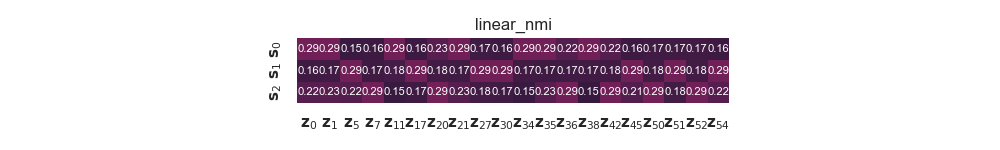

In [40]:
plot_mi_heatmap(linear_metrics, 'linear_nmi')

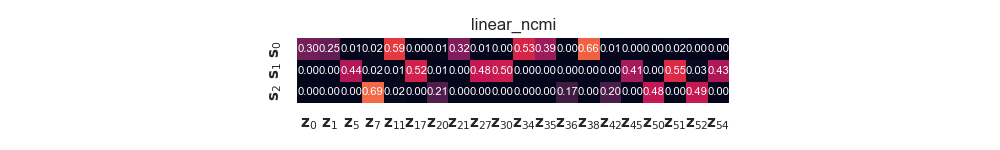

In [41]:
plot_mi_heatmap(linear_metrics, 'linear_ncmi')


In [38]:
linear_metrics_removed = compute_linear_metrics(s[:, :2], z, 'discrete', 'continuous')


/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: User

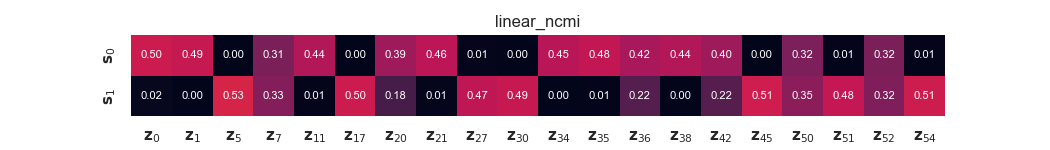

In [46]:
plot_mi_heatmap(linear_metrics_removed, 'linear_ncmi')


In [30]:
api = wandb.Api()
run_path = 'iris_viscam/modular/2rz2ch6t'
step = 99999
run = api.run(run_path)
config = omegaconf.OmegaConf.create(run.config)

keys = iter(jax.random.split(jax.random.PRNGKey(config.experiment.seed), 100))
model = hydra.utils.instantiate(config.model)(key=next(keys))
model_file = wandb.restore(f'checkpoints/step={step}/model.eqx', run_path=run_path)
model = eqx.tree_deserialise_leaves(model_file.name, model)

data_key = jax.random.PRNGKey(config.data.seed)
dataset = generate_square_data(
                config.data.d_source,
                config.data.n_values_per_source,
                config.data.slice,
                config.data.correlated_sampling_factor,
                config.data.covariance,
                key=data_key
            )
train_set = tf.data.Dataset.from_tensor_slices(dataset)
val_set = train_set.shuffle(train_set.cardinality(), seed=config.data.seed).take(config.data.n_val)
val_set = val_set.batch(config.data.batch_size) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = tfds.as_numpy(val_set)
auxs = []
key = next(keys)
for i, batch in enumerate(val_set):
    key, sub_key = jax.random.split(key)
    _, aux = model.loss(model, batch, key=sub_key)
    aux['x'] = batch['x']
    aux['s'] = batch['s']
    auxs.append(aux)

auxs = jax.tree.map(lambda *leaves: jnp.concatenate(leaves) if leaves[0].ndim > 0 else jnp.stack(leaves), *auxs)

2024-05-21 00:57:18.978399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [54]:
import metrics
importlib.reload(metrics)
pprint(metrics.compute_metrics(auxs['s'], auxs['z'], 'discrete', 'continuous'))

/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


{'cinfoc': Array(0., dtype=float32),
 'cinfom': 0.0,
 'infoc': Array(0.08019476, dtype=float32),
 'infoe': 0.9279558833296703,
 'infom': 0.2372467484954488,
 'linear_cinfoc': Array(0.3337327, dtype=float32),
 'linear_cinfom': 1.0,
 'linear_ncmi': array([[0.41169753, 0.        , 0.        , 0.41256484],
       [0.        , 0.40128764, 0.40140463, 0.        ]]),
 'ncmi': array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]),
 'nmi': array([[0.96968901, 0.60474432, 0.604503  , 0.95941239],
       [0.58840188, 0.97143495, 0.9712198 , 0.58940318]]),
 'z_active': Array([ True,  True,  True,  True], dtype=bool)}


/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [37]:
pprint(metrics.compute_metrics(auxs['s'], auxs['z'], 'discrete', 'discrete'))


{'cinfoc': Array(0., dtype=float32),
 'cinfom': 0.0016712239640883642,
 'infoc': Array(0., dtype=float32),
 'infoe': 0.9842226626354909,
 'infom': 0.0008337880205928627,
 'ncmi': array([[0.99329229, 0.99329229, 0.99329229, 0.99329229],
       [0.98997781, 0.98997781, 0.98997781, 0.98997781]]),
 'nmi': array([[0.98736792, 0.98736792, 0.98736792, 0.98736792],
       [0.98572278, 0.98572278, 0.98572278, 0.98572278]]),
 'z_active': Array([ True,  True,  True,  True], dtype=bool)}


In [11]:
s = np.mgrid[0:1:11j, 0:1:11j]
s = s.reshape(2, -1).T
slice = 0
s = s[s[:, 1] >= -s[:, 0] + slice]
pprint(metrics.compute_metrics(s, s))

{'cinfoc': 0.9981406667028545,
 'cinfom': 0.9981492007789792,
 'infoc': 1.0,
 'infoe': 0.9999344137281407,
 'infom': 1.0,
 'ncmi': array([[0.99811074, 0.00185928],
       [0.        , 1.00272163]]),
 'nmi': array([[1.00086235, 0.        ],
       [0.        , 1.00086235]]),
 'z_active': array([ True,  True])}


/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [18]:
s = np.mgrid[0:1:11j, 0:1:11j]
s = s.reshape(2, -1).T
slice = 0.5
s = s[s[:, 1] >= -s[:, 0] + slice]
z = s.copy()
z[:, -1] *= 1e-3
z.numel() * 4 / 1024 / 1024
pprint(metrics.compute_metrics(s, z))

AttributeError: 'numpy.ndarray' object has no attribute 'numel'

In [14]:
np.max(z, axis=0) - np.min(z, axis=0)

array([1.e+00, 1.e-07])

In [13]:
s = np.mgrid[0:1:11j, 0:1:11j]
s = s.reshape(2, -1).T
slice = 1.
s = s[s[:, 1] >= -s[:, 0] + slice]
pprint(metrics.compute_metrics(s, s))

{'cinfoc': 1.0,
 'cinfom': 1.0,
 'infoc': 0.7858851840884387,
 'infoe': 0.9998921156030449,
 'infom': 0.7858855558308169,
 'ncmi': array([[1.00609001, 0.        ],
       [0.        , 1.00632463]]),
 'nmi': array([[1.00152391, 0.11880434],
       [0.12132096, 1.00128751]]),
 'z_active': array([ True,  True])}


/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [14]:
s = np.mgrid[0:1:31j, 0:1:31j]
s = s.reshape(2, -1).T
slice = 1.
s = s[s[:, 1] >= -s[:, 0] + slice]
pprint(metrics.compute_metrics(s, s))

/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


{'cinfoc': 0.9980132527024852,
 'cinfom': 0.9980132741728238,
 'infoc': 0.835944239424224,
 'infoe': 0.9997857962828036,
 'infom': 0.8359442063233415,
 'ncmi': array([[1.00691366, 0.        ],
       [0.00200444, 1.00690276]]),
 'nmi': array([[1.0004467 , 0.08708482],
       [0.0917212 , 1.00045684]]),
 'z_active': array([ True,  True])}


/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [15]:
s_and_z = np.load('s_and_z_101.npz', allow_pickle=True)
s = s_and_z['s']
z = s_and_z['z']
pprint(metrics.compute_metrics(s, z))


/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/kylehsu/miniforge3/envs/modular/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


{'cinfoc': 0.18194358092044371,
 'cinfom': 0.546083377418566,
 'infoc': 0.15002373195225407,
 'infoe': 0.9995844339208685,
 'infom': 0.45013099919029753,
 'ncmi': array([[1.0037588 , 0.38625516, 0.33311998, 1.00374949],
       [0.23854583, 1.0036264 , 1.003683  , 0.23348896]]),
 'nmi': array([[0.99970045, 0.45874914, 0.41225953, 0.99992858],
       [0.32934197, 0.99957503, 0.99968203, 0.32514818]]),
 'z_active': array([ True,  True,  True,  True])}
